# Предсказание калорийности блюд


In [7]:
# Импорт необходимых библиотек
import sys
sys.path.append('.')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Настройка стиля для графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Импорт наших модулей
from scripts.dataset import CalorieDataset, get_default_transforms, load_data
from scripts.model import create_model
from scripts.utils import set_seed, train, compute_metrics, validate_epoch

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## Часть 1: EDA (Исследовательский анализ данных)


In [2]:
# Загрузка данных
print("Загрузка данных...")
dish_df, ingredients_df = load_data(data_dir='nutrition/data')

print(f"\nРазмер датасета dishes: {dish_df.shape}")
print(f"Размер датасета ingredients: {ingredients_df.shape}")

print("\nПервые строки dish.csv:")
print(dish_df.head())


Загрузка данных...

Размер датасета dishes: (3262, 5)
Размер датасета ingredients: (555, 2)

Первые строки dish.csv:
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train  


In [3]:
# Базовая статистика
print("Статистика калорийности:")
print(dish_df['total_calories'].describe())

print("\nСтатистика массы:")
print(dish_df['total_mass'].describe())

print("\nРазделение данных:")
print(dish_df['split'].value_counts())


Статистика калорийности:
count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64

Статистика массы:
count    3262.000000
mean      214.980074
std       161.497428
min         1.000000
25%        92.000000
50%       177.000000
75%       305.000000
max      3051.000000
Name: total_mass, dtype: float64

Разделение данных:
split
train    2755
test      507
Name: count, dtype: int64


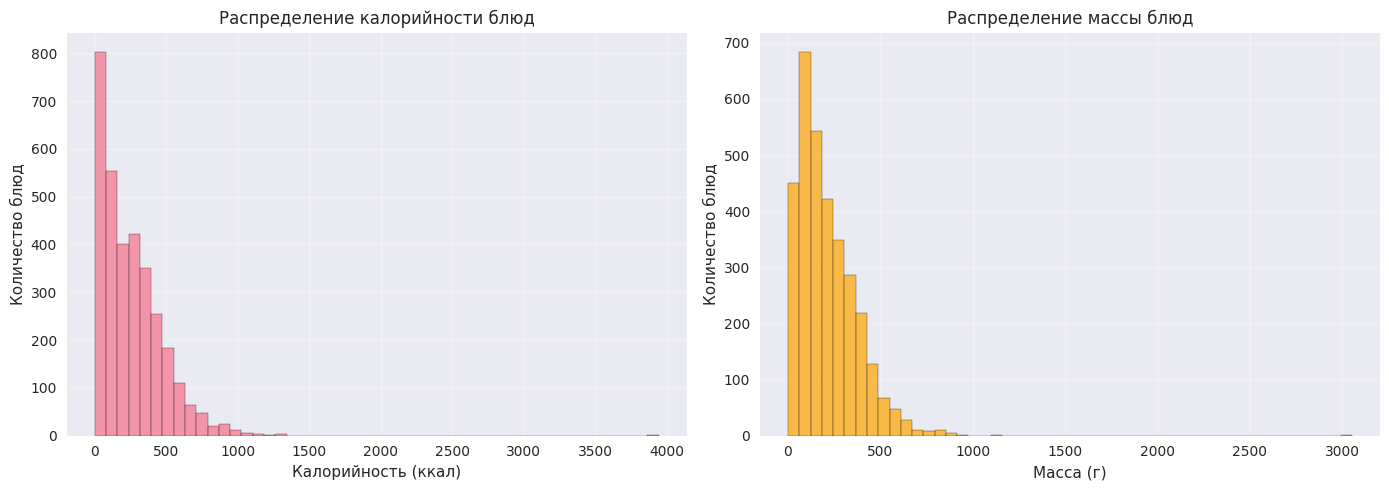


Корреляция между массой и калорийностью: 0.760


In [ ]:
# Визуализация распределения калорийности
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Распределение калорийности
axes[0].hist(dish_df['total_calories'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Калорийность (ккал)')
axes[0].set_ylabel('Количество блюд')
axes[0].set_title('Распределение калорийности блюд')
axes[0].grid(True, alpha=0.3)

# Распределение массы
axes[1].hist(dish_df['total_mass'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Масса (г)')
axes[1].set_ylabel('Количество блюд')
axes[1].set_title('Распределение массы блюд')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Корреляция между массой и калорийностью
correlation = dish_df['total_calories'].corr(dish_df['total_mass'])
print(f"\nКорреляция между массой и калорийностью: {correlation:.3f}")


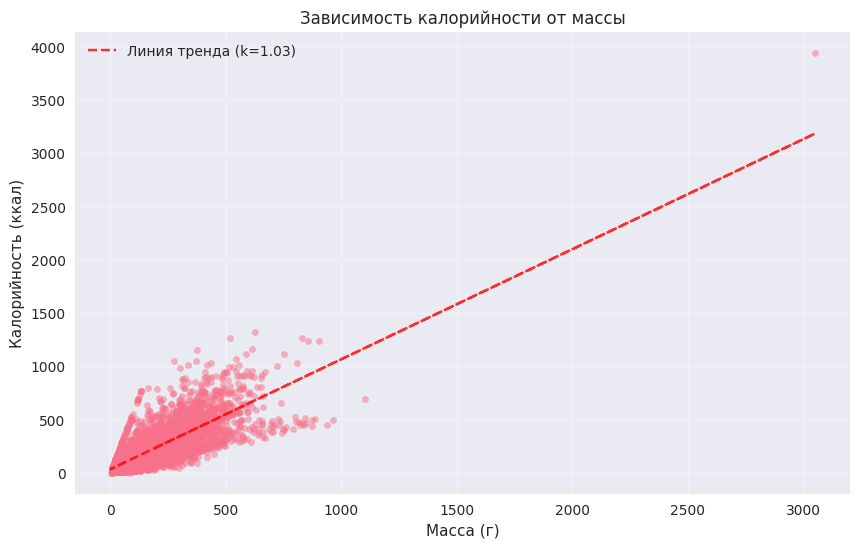

In [ ]:
# Визуализация зависимости калорийности от массы
plt.figure(figsize=(10, 6))
plt.scatter(dish_df['total_mass'], dish_df['total_calories'], alpha=0.5, s=20)
plt.xlabel('Масса (г)')
plt.ylabel('Калорийность (ккал)')
plt.title('Зависимость калорийности от массы')
plt.grid(True, alpha=0.3)

# Добавление линии тренда
z = np.polyfit(dish_df['total_mass'], dish_df['total_calories'], 1)
p = np.poly1d(z)
plt.plot(dish_df['total_mass'], p(dish_df['total_mass']), "r--", alpha=0.8, label=f'Линия тренда (k={z[0]:.2f})')
plt.legend()


Статистика по количеству ингредиентов:
count    3262.000000
mean        7.313305
std         6.943276
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max        34.000000
Name: num_ingredients, dtype: float64


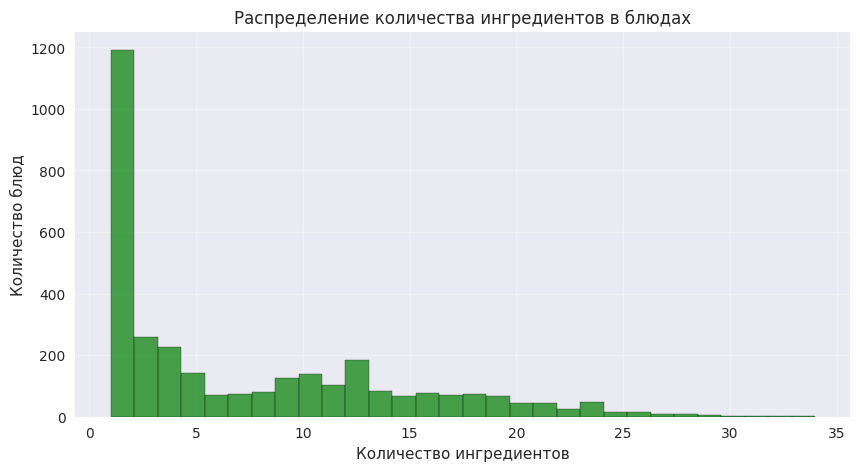

In [ ]:
# Анализ количества ингредиентов
dish_df['num_ingredients'] = dish_df['ingredients'].apply(lambda x: len(x.split(';')))

print("Статистика по количеству ингредиентов:")
print(dish_df['num_ingredients'].describe())

plt.figure(figsize=(10, 5))
plt.hist(dish_df['num_ingredients'], bins=30, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество блюд')
plt.title('Распределение количества ингредиентов в блюдах')
plt.grid(True, alpha=0.3)


Примеры блюд из датасета:


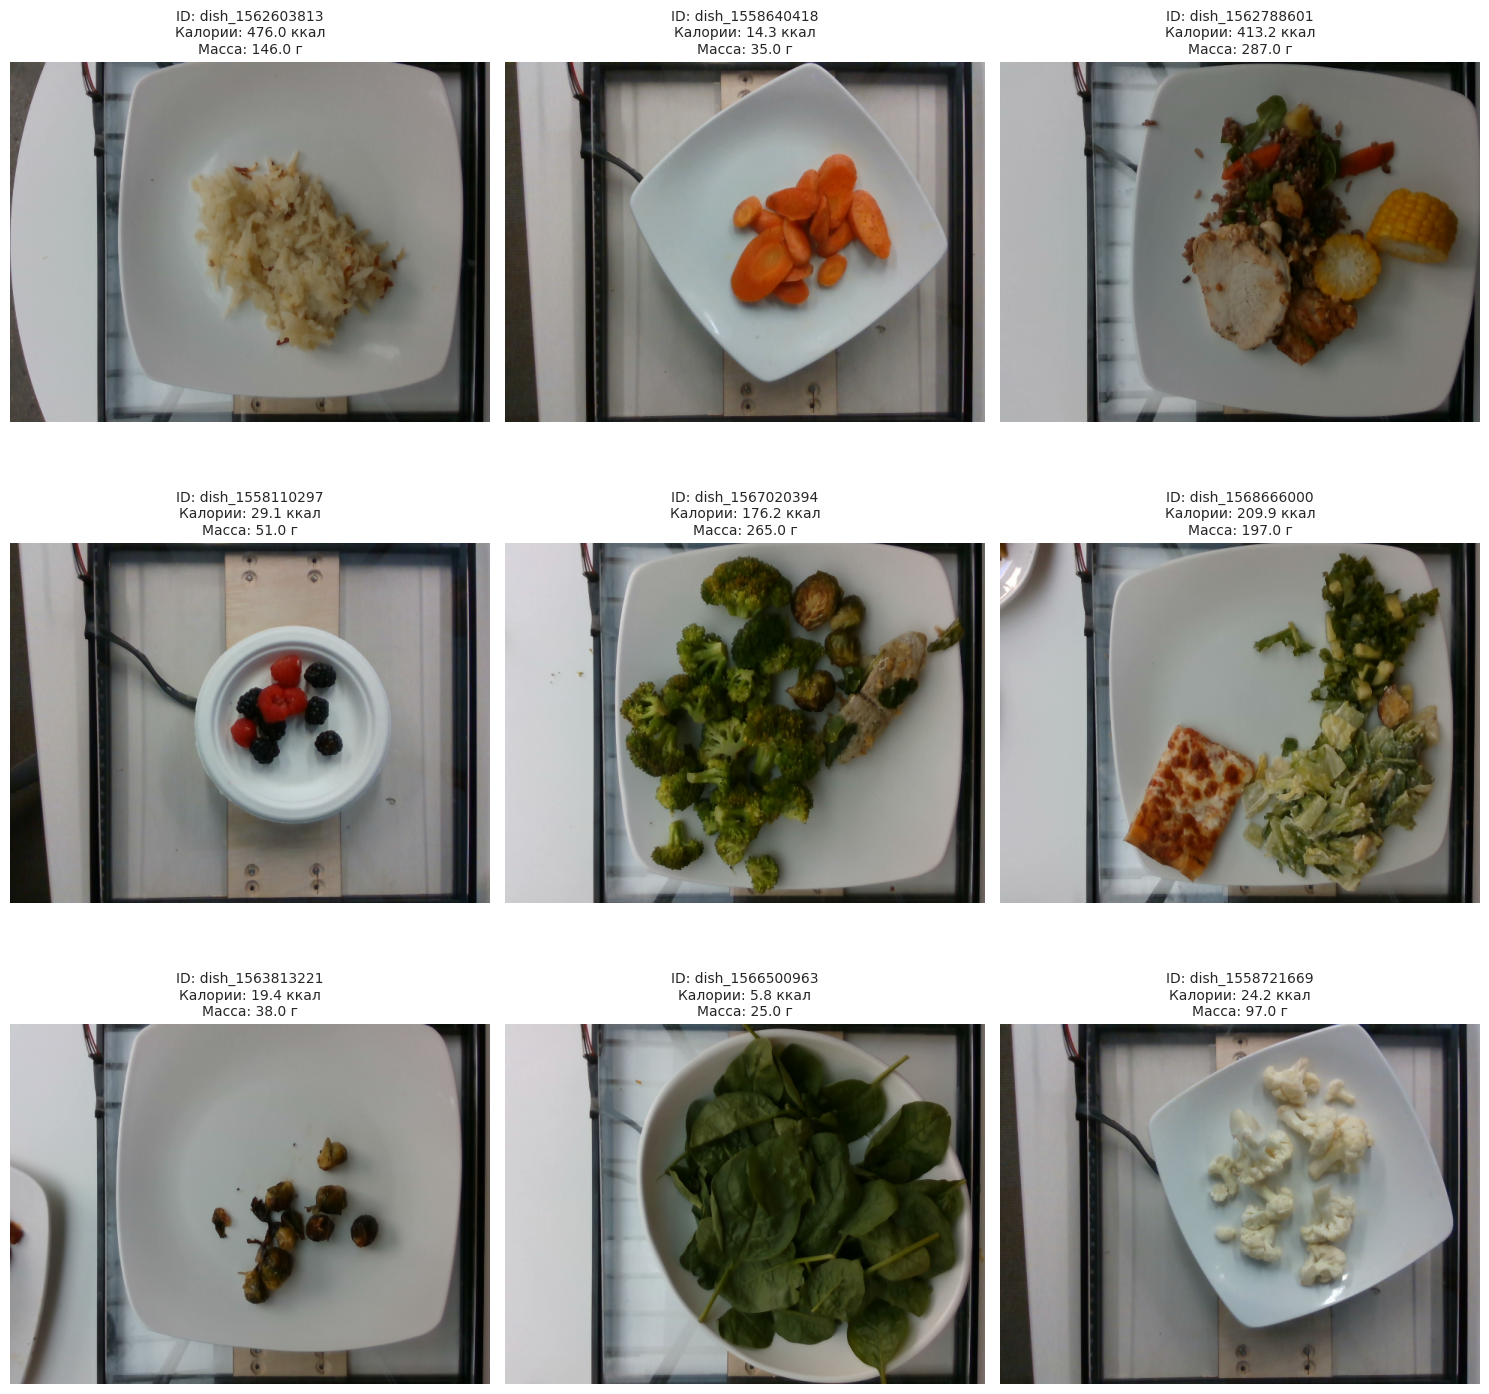

In [ ]:
# Визуализация примеров изображений
import os

def visualize_samples(dish_df, num_samples=9):
    """Визуализировать примеры блюд"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    sample_indices = np.random.choice(len(dish_df), num_samples, replace=False)
    
    for idx, ax in enumerate(axes):
        row = dish_df.iloc[sample_indices[idx]]
        dish_id = row['dish_id']
        image_path = f'nutrition/data/images/{dish_id}/rgb.png'
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            ax.imshow(img)
            ax.set_title(f"ID: {dish_id}\nКалории: {row['total_calories']:.1f} ккал\nМасса: {row['total_mass']} г", 
                        fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()

# Визуализация примеров
print("Примеры блюд из датасета:")
visualize_samples(dish_df)


### Выводы по EDA:
Видно, что тарелки разные, это может сыграть как в плюс так и в минус. Например, калорийность блюда не должна зависеть от формы тарелки, но можно использовать это как аугментацию.
Будем использовать мультимодальную модель, сочетающую визуальные признаки и структурированные данные


## Часть 2: Обучение модели


In [2]:
# Обучение модели
set_seed(42)
print("Начало обучения модели...")

results = train(config_path='config.yaml')


Начало обучения модели...
Используется устройство: cuda

Загрузка данных...
Создание датасетов...
Размер обучающей выборки: 2755
Размер тестовой выборки: 507
Количество уникальных ингредиентов: 555

Создание модели...

Начало обучения...

Эпоха 1/30


Training: 100%|██████████| 87/87 [00:26<00:00,  3.32it/s]


Train - Loss: 131.1320, MAE: 131.4231


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Val - Loss: 105.2984, MAE: 105.6804
Лучшая модель сохранена (MAE: 105.6804)

Эпоха 2/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.43it/s]


Train - Loss: 103.8056, MAE: 103.9769


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


Val - Loss: 95.5726, MAE: 96.0021
Лучшая модель сохранена (MAE: 96.0021)

Эпоха 3/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.41it/s]


Train - Loss: 92.2235, MAE: 93.0042


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


Val - Loss: 100.5680, MAE: 101.0270

Эпоха 4/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.39it/s]


Train - Loss: 88.0722, MAE: 87.2933


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]


Val - Loss: 81.0447, MAE: 81.2045
Лучшая модель сохранена (MAE: 81.2045)

Эпоха 5/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.39it/s]


Train - Loss: 82.2400, MAE: 82.8107


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


Val - Loss: 92.6871, MAE: 93.0809

Эпоха 6/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.38it/s]


Train - Loss: 83.8632, MAE: 82.0494


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


Val - Loss: 77.0042, MAE: 77.1614
Лучшая модель сохранена (MAE: 77.1614)

Эпоха 7/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.38it/s]


Train - Loss: 80.1527, MAE: 80.4374


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]


Val - Loss: 75.7797, MAE: 75.9626
Лучшая модель сохранена (MAE: 75.9626)

Эпоха 8/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.38it/s]


Train - Loss: 77.8121, MAE: 78.4548


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]


Val - Loss: 73.4553, MAE: 73.4752
Лучшая модель сохранена (MAE: 73.4752)

Эпоха 9/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.38it/s]


Train - Loss: 77.0837, MAE: 76.9877


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


Val - Loss: 71.5661, MAE: 71.6020
Лучшая модель сохранена (MAE: 71.6020)

Эпоха 10/30


Training: 100%|██████████| 87/87 [00:25<00:00,  3.36it/s]


Train - Loss: 76.8784, MAE: 76.0329


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]


Val - Loss: 70.1838, MAE: 70.2081
Лучшая модель сохранена (MAE: 70.2081)
Разблокировка весов image_encoder...

Эпоха 11/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.91it/s]


Train - Loss: 72.8971, MAE: 73.5628


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


Val - Loss: 59.1441, MAE: 59.2699
Лучшая модель сохранена (MAE: 59.2699)

Эпоха 12/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 68.4849, MAE: 69.0794


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


Val - Loss: 60.5096, MAE: 60.7227

Эпоха 13/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 63.1846, MAE: 63.2598


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


Val - Loss: 52.5920, MAE: 52.6267
Лучшая модель сохранена (MAE: 52.6267)

Эпоха 14/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 60.5606, MAE: 60.4589


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


Val - Loss: 62.5481, MAE: 62.7816

Эпоха 15/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.89it/s]


Train - Loss: 60.2017, MAE: 59.8272


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


Val - Loss: 50.3784, MAE: 50.5801
Лучшая модель сохранена (MAE: 50.5801)

Эпоха 16/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 57.9154, MAE: 58.3234


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Val - Loss: 49.8328, MAE: 49.9326
Лучшая модель сохранена (MAE: 49.9326)

Эпоха 17/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 58.8030, MAE: 58.2066


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


Val - Loss: 49.7877, MAE: 49.8919
Лучшая модель сохранена (MAE: 49.8919)

Эпоха 18/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 58.0702, MAE: 57.3096


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


Val - Loss: 44.8805, MAE: 44.9250
Лучшая модель сохранена (MAE: 44.9250)

Эпоха 19/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 54.6185, MAE: 54.3095


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


Val - Loss: 45.4448, MAE: 45.5612

Эпоха 20/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 56.5063, MAE: 56.5743


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


Val - Loss: 58.5323, MAE: 58.8084

Эпоха 21/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 57.2948, MAE: 56.7651


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


Val - Loss: 49.3307, MAE: 49.5001

Эпоха 22/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 54.7248, MAE: 55.0115


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]


Val - Loss: 44.6033, MAE: 44.7119
Лучшая модель сохранена (MAE: 44.7119)

Эпоха 23/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 51.8478, MAE: 51.8611


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


Val - Loss: 44.2764, MAE: 44.4020
Лучшая модель сохранена (MAE: 44.4020)

Эпоха 24/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 50.8819, MAE: 50.9372


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]


Val - Loss: 56.2830, MAE: 56.4814

Эпоха 25/30


Training: 100%|██████████| 87/87 [00:46<00:00,  1.89it/s]


Train - Loss: 52.4066, MAE: 52.7501


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


Val - Loss: 42.2704, MAE: 42.3295
Лучшая модель сохранена (MAE: 42.3295)

Эпоха 26/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 50.4779, MAE: 50.5391


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Val - Loss: 42.7893, MAE: 42.8637

Эпоха 27/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.90it/s]


Train - Loss: 51.9097, MAE: 51.5829


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Val - Loss: 41.4931, MAE: 41.6258
Лучшая модель сохранена (MAE: 41.6258)

Эпоха 28/30


Training: 100%|██████████| 87/87 [00:45<00:00,  1.89it/s]


Train - Loss: 50.0163, MAE: 50.3468


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


Val - Loss: 50.6638, MAE: 50.8520

Эпоха 29/30


Training: 100%|██████████| 87/87 [00:46<00:00,  1.89it/s]


Train - Loss: 49.9755, MAE: 50.3066


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


Val - Loss: 50.7084, MAE: 50.9287

Эпоха 30/30


Training: 100%|██████████| 87/87 [00:46<00:00,  1.89it/s]


Train - Loss: 50.7537, MAE: 50.8759


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]

Val - Loss: 44.5598, MAE: 44.6440

Обучение завершено! Лучший MAE на валидации: 41.6258


Лучший MAE на валидации: 41.6258


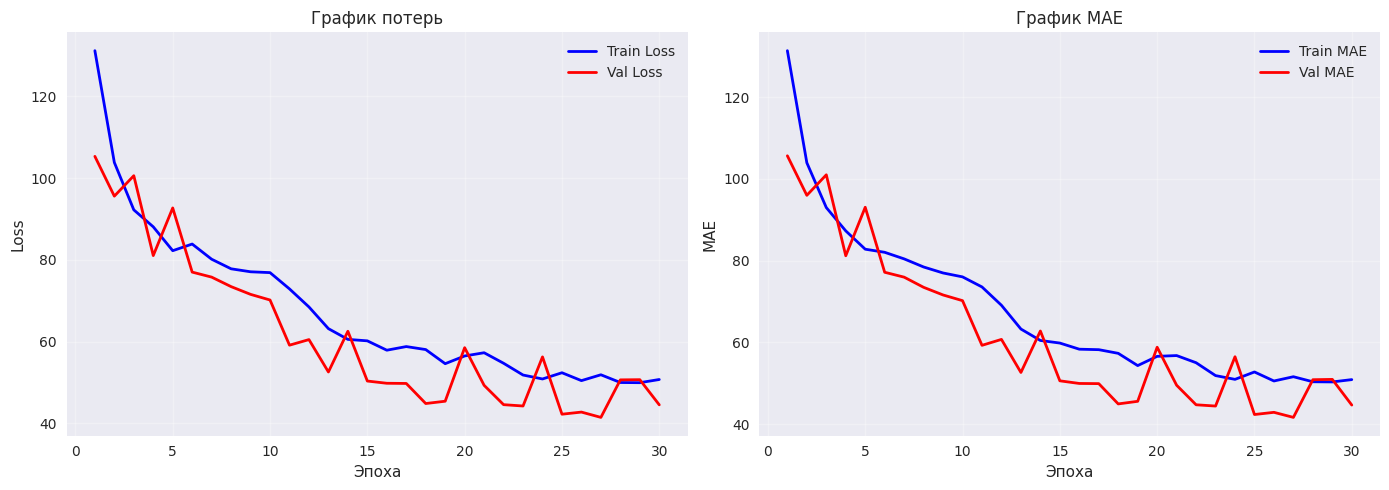

In [9]:
# Визуализация истории обучения
train_history = results['train_history']
val_history = results['val_history']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(train_history) + 1)

# График потерь
axes[0].plot(epochs, [h['loss'] for h in train_history], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, [h['loss'] for h in val_history], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].set_title('График потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График MAE
axes[1].plot(epochs, [h['MAE'] for h in train_history], 'b-', label='Train MAE', linewidth=2)
axes[1].plot(epochs, [h['MAE'] for h in val_history], 'r-', label='Val MAE', linewidth=2)
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('MAE')
axes[1].set_title('График MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

print(f"Лучший MAE на валидации: {results['best_val_mae']:.4f}")


## Часть 3: Валидация качества


In [11]:
# Загрузка лучшей модели и инференс на тестовой выборке
import yaml

with open('config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

dish_df, ingredients_df = load_data(data_dir=config['data']['data_dir'])

test_transform = get_default_transforms(config['data']['image_size'], is_train=False)
test_dataset = CalorieDataset(dish_df, ingredients_df, images_dir=config['data']['images_dir'], split='test', transform=test_transform, max_ingredients=config['data']['max_ingredients'])
test_loader = DataLoader(test_dataset, batch_size=config['training']['batch_size'], shuffle=False, num_workers=config['training']['num_workers'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_ingredients=test_dataset.num_ingredients, max_ingredients=config['data']['max_ingredients'], image_embedding_dim=config['model']['image_embedding_dim'], ingredient_embedding_dim=config['model']['ingredient_embedding_dim'], hidden_dims=tuple(config['model']['hidden_dims']), dropout=config['model']['dropout'])
model.load_state_dict(torch.load(config['training']['model_save_path'], map_location=device))
model = model.to(device)
model.eval()

print("Модель загружена и готова к инференсу")


Модель загружена и готова к инференсу


In [12]:
# Вычисление финальных метрик на тестовой выборке
criterion = nn.L1Loss()
test_metrics = validate_epoch(model, test_loader, criterion, device)

print("=" * 60)
print("ФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("=" * 60)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")
print("=" * 60)

Validation: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

ФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
MAE: 41.6258
MSE: 4062.5478
RMSE: 63.7381
MAPE: inf
loss: 41.4931


In [ ]:
# Инференс и анализ топ-5 блюд
model.eval()
all_predictions, all_targets, all_indices = [], [], []

with torch.no_grad():
    for batch_idx, (images, ingredients_ids, attention_masks, masses, calories) in enumerate(test_loader):
        images = images.to(device)
        ingredients_ids = ingredients_ids.to(device)
        attention_masks = attention_masks.to(device)
        masses = masses.to(device)
        outputs = model(images, ingredients_ids, attention_masks, masses).squeeze()
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(calories.numpy())
        all_indices.extend(range(batch_idx * len(calories), (batch_idx + 1) * len(calories)))

all_predictions, all_targets, all_indices = np.array(all_predictions), np.array(all_targets), np.array(all_indices)
errors = np.abs(all_predictions - all_targets)
top_5_worst_idx = np.argsort(errors)[-10:][::-1]




Топ-10 блюд с наибольшей ошибкой предсказания:
--------------------------------------------------------------------------------


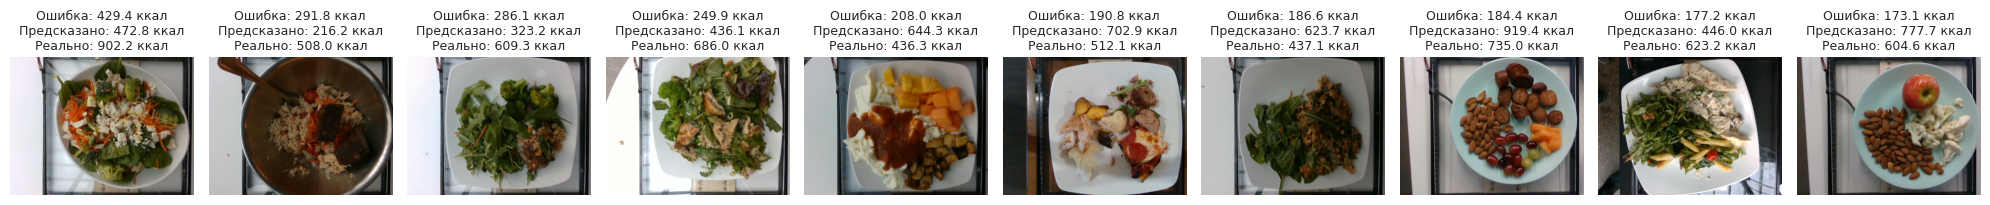

In [24]:
# Визуализация топ-5 блюд
fig, axes = plt.subplots(1, 10, figsize=(20, 4))

for i, worst_idx in enumerate(top_5_worst_idx):
    dataset_idx = all_indices[worst_idx]
    row = test_dataset.dish_df.iloc[dataset_idx]
    dish_id = row['dish_id']
    image_path = f'nutrition/data/images/{dish_id}/rgb.png'
    img = Image.open(image_path)
    axes[i].imshow(img)
    pred, target, error = all_predictions[worst_idx], all_targets[worst_idx], errors[worst_idx]
    axes[i].set_title(f"Ошибка: {error:.1f} ккал\nПредсказано: {pred:.1f} ккал\nРеально: {target:.1f} ккал", fontsize=9)
    axes[i].axis('off')

plt.tight_layout()

Видно, что хуже скорее всего получается предсказать из за большой смеси продуктов, где много разных ингридиентов


Топ-5 блюд с наименьшей ошибкой предсказания:
--------------------------------------------------------------------------------


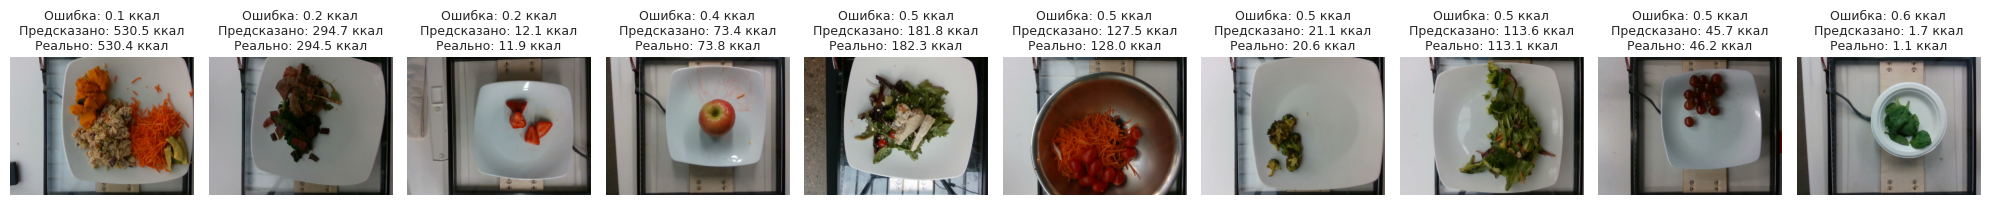

In [20]:
# Топ-5 самых точных предсказаний
top_5_best_idx = np.argsort(errors)[:10]

print("\nТоп-5 блюд с наименьшей ошибкой предсказания:")
print("-" * 80)

# Визуализация топ-5 лучших предсказаний
fig, axes = plt.subplots(1, 10, figsize=(20, 4))

for i, best_idx in enumerate(top_5_best_idx):
    dataset_idx = all_indices[best_idx]
    row = test_dataset.dish_df.iloc[dataset_idx]
    dish_id = row['dish_id']
    image_path = f'nutrition/data/images/{dish_id}/rgb.png'
    img = Image.open(image_path)
    axes[i].imshow(img)
    pred, target, error = all_predictions[best_idx], all_targets[best_idx], errors[best_idx]
    axes[i].set_title(f"Ошибка: {error:.1f} ккал\nПредсказано: {pred:.1f} ккал\nРеально: {target:.1f} ккал", fontsize=9)
    axes[i].axis('off')

plt.tight_layout()

Видно, что модель предсказывет очень точно одиночные продукты, хотя иногда и получается что смешанные блюда тоже хорошо предсказываются
